<a href="https://colab.research.google.com/github/suhabae/weatherfitsAPI/blob/main/suha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
from sklearn.model_selection import train_test_split
import random

In [ ]:
import os

os.makedirs('/content/data/raw/suha', exist_ok=True)


In [ ]:
# 압축 파일로 서로 공유하시는게 편하시다면 아래 코드를 실행해 주시면 됩니다. 자동으로 /content 아래에 압축 풀기 해줘요.
import zipfile

# 압축 파일 경로
zip_file_path = '/content/zipfile.zip/'
extract_dir = '/content/'

# 압축 파일 풀기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
# 데이터 경로 설정
data_dir = '/content/data/raw/'
# 폴더 이름입니다. 실제 폴더 명으로 변경해 주세요.
members = ['suha']


# 각 멤버별 이미지 파일 개수 확인
for member in members:
    member_dir = os.path.join(data_dir, member)
    files = os.listdir(member_dir)
    print(f"{member}의 이미지 개수: {len(files)}")
    print(f"샘플 파일 이름: {files[:3]}")

suha의 이미지 개수: 20
샘플 파일 이름: ['baesuha (3).jpg', 'baesuha (20).jpg', 'baesuha (9).jpg']


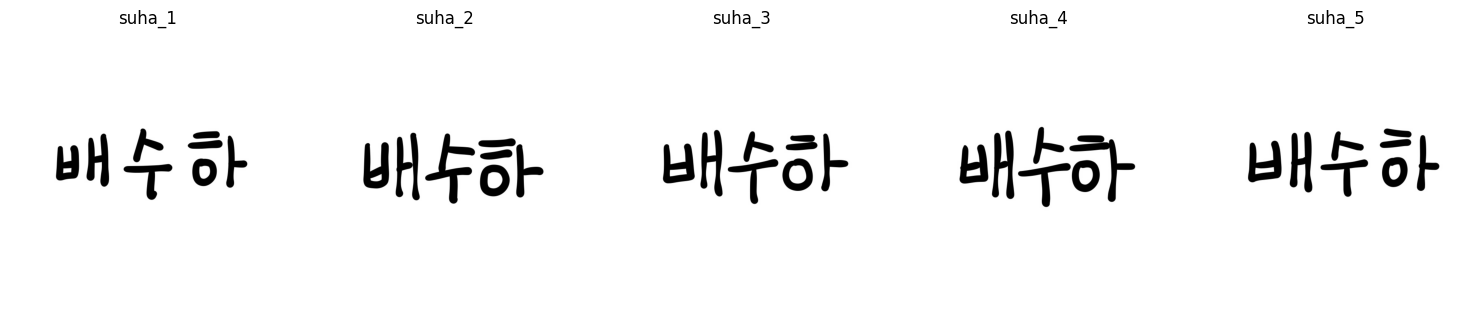

In [ ]:
# 각 멤버별 샘플 이미지 시각화
plt.figure(figsize=(15, 12))
for i, member in enumerate(members):
    member_dir = os.path.join(data_dir, member)
    files = os.listdir(member_dir)

    for j in range(5):  # 각 멤버당 5개 이미지 표시
        if j < len(files):
            img_path = os.path.join(member_dir, files[j])
            img = cv2.imread(img_path)

            # 이미지 로딩 성공 여부 확인
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                plt.subplot(4, 5, i*5 + j + 1)
                plt.imshow(img)
                plt.title(f"{member}_{j+1}")
                plt.axis('off')
            else:
                # 이미지 로딩 실패 시 메시지 출력
                print(f"Warning: Failed to load image: {img_path}")
                # Optionally, you can skip the subplot for this image or show a placeholder
                # For now, we will just skip it and print a warning.


plt.tight_layout()
plt.show()

In [ ]:
# 데이터를 불러와서 각 변수에 저장
train_dir = '/content/data/raw'
test_dir = '/content/data/raw'
image_size = (150, 150)

# 1. 데이터 증강 준비 및 설정
# 증강이 포함된 학습 데이터 제너레이터
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,          # 데이터 정규화(이미지 파일의 픽셀값은 0~255입니다.
                                # 이를 모델이 학습할 수 있도록 0.0~1.0 사이의 값으로 바꿔줍니다.)

                                # 아래는 증강에 사용되는 값들입니다.

    rotation_range=10,          # 회전 각도 범위
    width_shift_range=0.1,      # 수평 이동 범위
    height_shift_range=0.1,     # 수직 이동 범위
    shear_range=0.1,            # 전단 변환 범위
    zoom_range=0.1,             # 확대/축소 범위
    fill_mode='nearest'         # 빈 픽셀 채우기 방식
)

# 테스트 데이터는 증강 없이 스케일링만 적용
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# 2. 학습 및 테스트 데이터 로드
# 학습 데이터와 테스트 데이터를 flow_from_directory로 로드
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=128,
    shuffle=False,
    seed=42
)


Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


클래스 이름: ['suha']
클래스 개수: 1
학습 데이터 배치 수: 1
테스트 데이터 배치 수: 1
이미지 크기: (150, 150), 채널: 1 (grayscale)


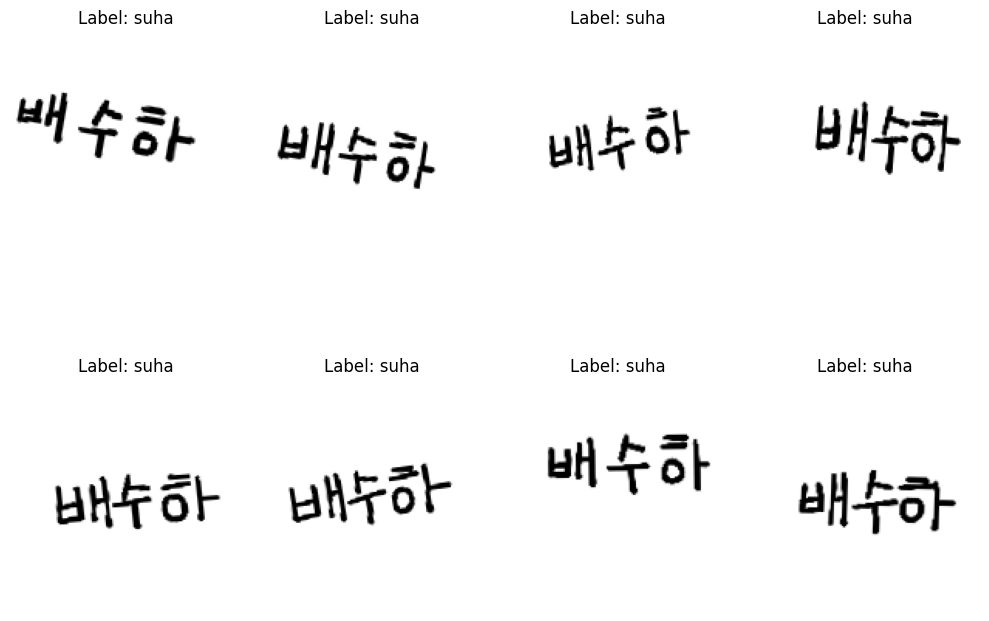

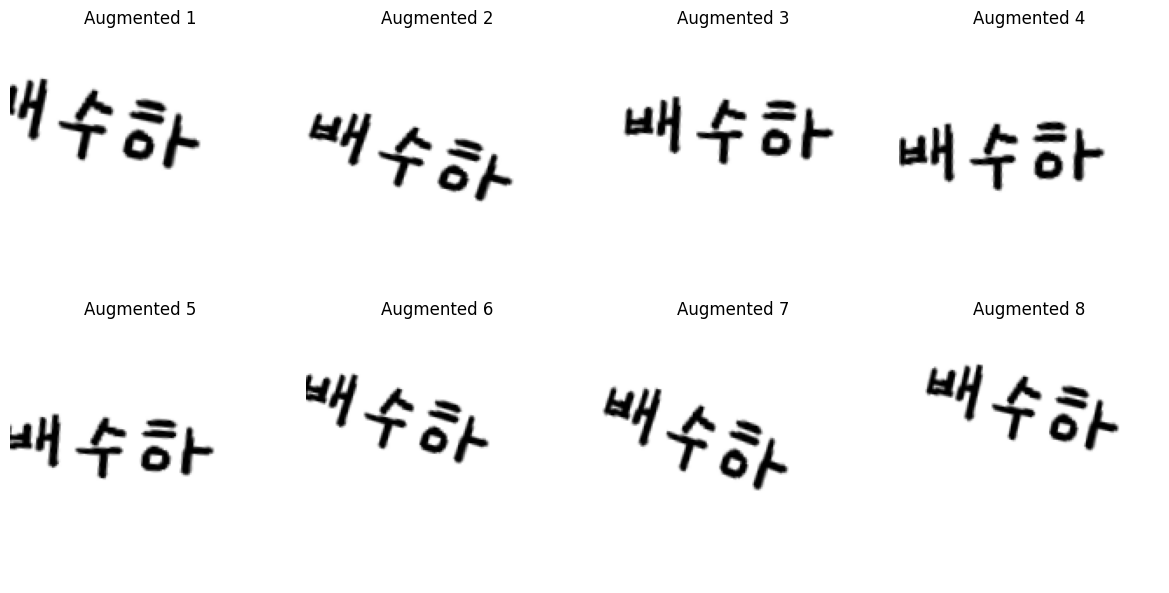


=== 데이터 증강 후 정보 ===
클래스 이름: ['suha']
클래스 개수: 1


NameError: name 'final_train_generator' is not defined

In [ ]:
# 3. 클래스 이름 및 개수 확인
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"클래스 이름: {class_names}")
print(f"클래스 개수: {num_classes}")

# 4. 데이터셋 정보 출력
print(f"학습 데이터 배치 수: {len(train_generator)}")
print(f"테스트 데이터 배치 수: {len(test_generator)}")
print(f"이미지 크기: {image_size}, 채널: 1 (grayscale)")

# 5. 원본 데이터 시각화
X_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 8))
for i in range(min(8, X_batch.shape[0])):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_batch[i].reshape(image_size), cmap='gray')
    # 레이블 인덱스를 클래스 이름으로 변환
    label_idx = np.argmax(y_batch[i])
    plt.title(f"Label: {class_names[label_idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 6. 증강된 이미지 시각화
# 하나의 이미지에 대한 증강 예시 보여주기
sample_image = X_batch[0:1]  # 하나의 이미지만 선택
sample_label = y_batch[0:1]  # 해당 레이블

plt.figure(figsize=(12, 6))
augmented_images = []
augmented_labels = []

# 데이터 증강 객체를 새로 만들어 단일 이미지에 적용
aug_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

# 증강된 이미지 시각화
i = 0
for x_batch, y_batch in aug_datagen.flow(sample_image, sample_label, batch_size=1, seed=42):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_batch[0].reshape(image_size), cmap='gray')
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

    augmented_images.append(x_batch[0])
    augmented_labels.append(y_batch[0])
    i += 1

    if i >= 8:  # 8개의 증강된 이미지 생성
        break

plt.tight_layout()
plt.show()


print("\n=== 데이터 증강 후 정보 ===")
print(f"클래스 이름: {class_names}")
print(f"클래스 개수: {num_classes}")
print(f"학습 데이터 배치 수: {len(final_train_generator)}")
print(f"테스트 데이터 배치 수: {len(test_generator)}")
print(f"이미지 크기: {image_size}, 채널: 1 (grayscale)")